## A/A тестирование
  В этом проекте мы будем проводить A/A тесты для сплит-системы и вычислять метрику качества FPR (будем проверять ее на конверсии в покупку). Выясним корректно ли работает сплит-система и, если нет, найдем причину поломки. 

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import statsmodels.api as sm

from tqdm.auto import tqdm

**Данные**: таблица с данными о покупках в мобильном приложении
- *experimentVariant* – вариант эксперимента
- *version* – версия приложения
- *purchase* – факт покупки

In [3]:
experiment = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';', index_col=0)
experiment.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [4]:
experiment.shape

(127018, 4)

In [ ]:
experiment.query('experimentVariant == 0').purchase

Проведем A/A тест и выясним в какой доли случаев между конверсией двух групп наблюдаются статистически значимые различия. 
Если система сплитования работает корректно, то распределение p-value на графике должно быть равномерным, и FPR приблизительно равен альфа. 

In [23]:
# Определим ф-цию для проведения A/A теста


def do_aatest(data1, data2, simulations=1000, n_s=1000):
    res = []

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = data1.sample(n_s, replace = False).values
        s2 = data2.sample(n_s, replace = False).values
        res.append(ss.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
    
    # Визуализация распределения p-value
    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()

    fpr = sum(np.array(res) <0.05) / simulations
    return print(f'Доля ложноположительных случаев превышающих альфу 0.05 (FPR): {fpr} ')

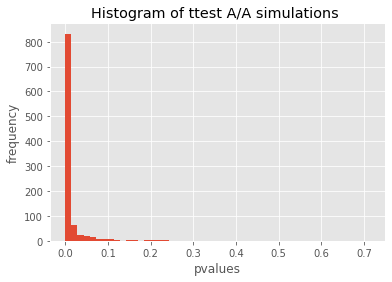

Доля ложноположительных случаев превышающих альфу 0.05 (FPR): 0.926 


In [24]:
variant0 = experiment.query('experimentVariant == 0').purchase 
variant1 = experiment.query('experimentVariant == 1').purchase 
do_aatest(variant0, variant1)

По результатам A/A теста более чем в 90% случаев конверсия в группах статистически различалась. Также видно, что распределение p-value сильно скошено в лево. 

Очевидно, что в системе сплитования имеется сбой. Попробуем найти его причину в версии приложения и равномерности разделения пользователей. 

In [17]:
(experiment.groupby(['experimentVariant', 'version'], as_index=False)
    .agg(conversion = ('purchase', 'mean'), user_count = ('uid', 'count')))

,experimentVariant,version,conversion,user_count
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


Пользователи разделены в две группы равномерно вне зависимости от версии приложения. Конверсия для версия приложения v2.9.0, v3.7.4.0 и v3.8.0.0 приблизительно одинаковая для обоих групп. Однако, конверия в версии v2.8.0 значительно отличается в двух эксперементальных группах (0.0001 против 0.045) при значительном объеме выборки (больше 41.000 наблюдений в каждой группе).

   Таким образом, мы формулируем гипотезу, что система сплитования ошибочно разделяет пользователей по группам из-за проблемы в версии приложения v2.8.0. Чтобы проверить гипотезу, исключим из данных всех пользователей с версией приложения v2.8.0 и проведем A/A тест еще раз

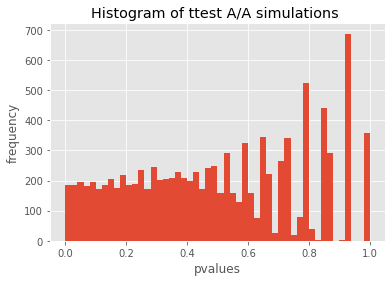

Доля ложноположительных случаев превышающих альфу 0.05 (FPR): 0.0471 


In [27]:
variant0_ = experiment.query('(experimentVariant == 0) & (version != "v2.8.0")').purchase 
variant1_ = experiment.query('(experimentVariant == 1) & (version != "v2.8.0")').purchase 
do_aatest(variant0_, variant1_, simulations=10000, n_s=1000)

Теперь FPR < альфа и распределение p-value гораздо более похоже на семитричное. Подтверждаем гипотезу о том, что сплит-система работает плохо из-за неверного разделения польозваетелей с версией приложения v2.8.0.